# VAE and Simple GAN Implementation

In [1]:
!unzip Extracted_Signatures.zip -d /content/Extracted_Signatures

Archive:  Extracted_Signatures.zip
   creating: /content/Extracted_Signatures/Extracted_Signatures/
   creating: /content/Extracted_Signatures/Extracted_Signatures/1/
  inflating: /content/Extracted_Signatures/Extracted_Signatures/1/Cell_1.jpg  
  inflating: /content/Extracted_Signatures/Extracted_Signatures/1/Cell_2.jpg  
  inflating: /content/Extracted_Signatures/Extracted_Signatures/1/Cell_3.jpg  
   creating: /content/Extracted_Signatures/Extracted_Signatures/10/
  inflating: /content/Extracted_Signatures/Extracted_Signatures/10/Cell_1.jpg  
  inflating: /content/Extracted_Signatures/Extracted_Signatures/10/Cell_2.jpg  
  inflating: /content/Extracted_Signatures/Extracted_Signatures/10/Cell_3.jpg  
   creating: /content/Extracted_Signatures/Extracted_Signatures/100/
  inflating: /content/Extracted_Signatures/Extracted_Signatures/100/Cell_1.jpg  
  inflating: /content/Extracted_Signatures/Extracted_Signatures/100/Cell_2.jpg  
  inflating: /content/Extracted_Signatures/Extracted_Sign

In [2]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

# Define transformations with augmentation
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale if not already
    transforms.Resize((64, 64)),  # Resize all images to 64x64 for consistency
    transforms.RandomRotation(1),  # Randomly rotate images for augmentation
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load the dataset
# Assume your dataset is located at "/content/signatures"
dataset_path = '/content/Extracted_Signatures/Extracted_Signatures'
full_dataset = ImageFolder(root=dataset_path, transform=transform)

In [3]:
from torch.utils.data import random_split

# Define the split ratio
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

# Randomly split the dataset
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Create DataLoaders for training and testing sets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        # Input: 1 x 64 x 64
        self.conv1 = nn.Conv2d(1, 64, 4, stride=2, padding=1)  # Output: 64 x 32 x 32
        self.conv2 = nn.Conv2d(64, 128, 4, stride=2, padding=1)  # Output: 128 x 16 x 16
        self.conv3 = nn.Conv2d(128, 256, 4, stride=2, padding=1)  # Output: 256 x 8 x 8
        self.conv4 = nn.Conv2d(256, 512, 4, stride=2, padding=1)  # Output: 512 x 4 x 4

        self.fc_mu = nn.Linear(512 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(512 * 4 * 4, latent_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(x.size(0), -1)  # Flatten
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 512 * 4 * 4)

        self.conv1 = nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1)  # Output: 256 x 8 x 8
        self.conv2 = nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1)  # Output: 128 x 16 x 16
        self.conv3 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)   # Output: 64 x 32 x 32
        self.conv4 = nn.ConvTranspose2d(64, 1, 4, stride=2, padding=1)     # Output: 1 x 64 x 64

    def forward(self, z):
        x = F.relu(self.fc(z))
        x = x.view(-1, 512, 4, 4)  # Reshape to match the dimensions
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.sigmoid(self.conv4(x))  # Ensure output is in the range [0, 1]
        return x

class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, mu, logvar

# Instantiate the model
latent_dim = 128
vae = VAE(latent_dim).to(device)


In [ ]:
def loss_function(reconstructed_x, x, mu, logvar):
    reconstruction_loss = F.mse_loss(reconstructed_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstruction_loss + kl_divergence

optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)

In [ ]:
def show_images(real, reconstructed, num_images=5):
    """
    Function to plot real images and their corresponding reconstructed images.
    """
    real = real.cpu().detach()
    reconstructed = reconstructed.cpu().detach()
    fig, axs = plt.subplots(2, num_images, figsize=(10, 4))
    for i in range(num_images):
        axs[0, i].imshow(real[i].squeeze(), cmap='gray')
        axs[0, i].set_title("Real")
        axs[0, i].axis('off')

        axs[1, i].imshow(reconstructed[i].squeeze(), cmap='gray')
        axs[1, i].set_title("Reconstructed")
        axs[1, i].axis('off')
    plt.show()

def train_vae(epochs):
    vae.train()
    for epoch in range(epochs):
        train_loss = 0
        for batch in train_loader:
            images, _ = batch
            images = images.to(device)
            optimizer.zero_grad()
            reconstructed, mu, logvar = vae(images)
            loss = loss_function(reconstructed, images, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {train_loss / len(train_loader.dataset):.4f}')

        # Visualize some real vs reconstructed images after each epoch
        vae.eval()
        with torch.no_grad():
            test_images, _ = next(iter(test_loader))
            test_images = test_images.to(device)
            reconstructed_test_images, _, _ = vae(test_images)
            show_images(test_images, reconstructed_test_images)
        vae.train()

# Train the VAE
train_vae(epochs=500)

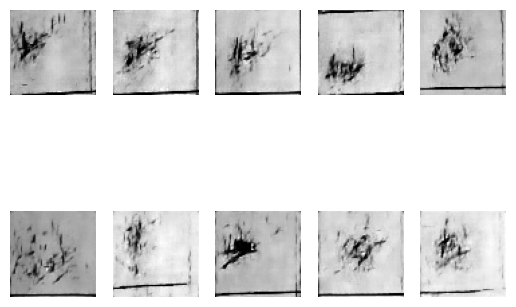

In [ ]:
def generate_vae_samples(num_samples):
    vae.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        generated_images = vae.decoder(z)
        generated_images = generated_images.cpu()
        return generated_images

# Generate 10 samples
samples = generate_vae_samples(10)
for i, img in enumerate(samples):
    plt.subplot(2, 5, i + 1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.axis('off')
plt.show()


# GAN Model

In [21]:
gan_loader = DataLoader(full_dataset, batch_size=64, shuffle=True)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision

# Define the generator
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.fc = nn.Linear(latent_dim, 64 * 16 * 16)
        self.conv1 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1)

    def forward(self, z):
        x = F.relu(self.fc(z))
        x = x.view(-1, 64, 16, 16)
        x = F.relu(self.conv1(x))
        x = torch.tanh(self.conv2(x))
        return x

# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2, padding=1)
        self.fc = nn.Linear(64 * 16 * 16, 1)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = x.view(x.size(0), -1)
        x = torch.sigmoid(self.fc(x))
        return x

# Create instances of the generator and discriminator
latent_dim = 128
device = 'cuda' if torch.cuda.is_available() else 'cpu'
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

# Set up the optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

# Define loss function
criterion = nn.BCELoss()

def plot_images(real_images, fake_images, epoch):
    plt.figure(figsize=(10, 5))

    # Display real images (first 5)
    plt.subplot(1, 2, 1)
    plt.title("Real Images")
    plt.axis('off')
    plt.imshow(torchvision.utils.make_grid(real_images[:5].cpu(), nrow=5, normalize=True).permute(1, 2, 0))

    # Display generated images (first 5)
    plt.subplot(1, 2, 2)
    plt.title("Generated Images")
    plt.axis('off')
    plt.imshow(torchvision.utils.make_grid(fake_images[:5].cpu(), nrow=5, normalize=True).permute(1, 2, 0))

    plt.suptitle(f'Epoch {epoch + 1}')
    plt.show()

# Function to train the GAN
def train_gan(epochs):
    for epoch in range(epochs):
        for real_images, _ in gan_loader:
            real_images = real_images.to(device)
            batch_size = real_images.size(0)

            # Create labels
            labels_real = torch.ones(batch_size, 1).to(device)
            labels_fake = torch.zeros(batch_size, 1).to(device)

            # Train Discriminator
            optimizer_D.zero_grad()
            output_real = discriminator(real_images)
            loss_real = criterion(output_real, labels_real)

            z = torch.randn(batch_size, latent_dim).to(device)
            fake_images = generator(z)
            output_fake = discriminator(fake_images.detach())
            loss_fake = criterion(output_fake, labels_fake)

            loss_D = loss_real + loss_fake
            loss_D.backward()
            optimizer_D.step()

            # Train Generator
            optimizer_G.zero_grad()
            output_fake = discriminator(fake_images)
            loss_G = criterion(output_fake, labels_real)  # Want generator to fool the discriminator
            loss_G.backward()
            optimizer_G.step()

        # Print loss values
        print(f'Epoch [{epoch + 1}/{epochs}], Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}')

        # Plot images every epoch
        with torch.no_grad():
            plot_images(real_images, fake_images, epoch)

# Assuming `train_loader` is defined elsewhere, e.g., using DataLoader
train_gan(epochs=1000)


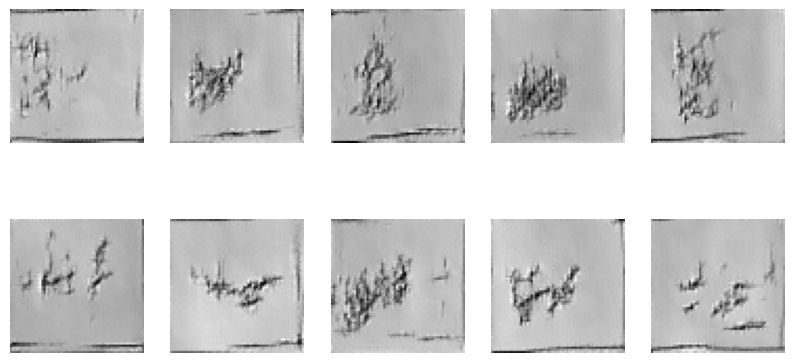

In [23]:
def generate_gan_samples(num_samples):
    generator.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        generated_images = generator(z)
        generated_images = generated_images.cpu()
        return generated_images

# Generate and display samples
num_samples = 10
samples = generate_gan_samples(num_samples)

# Plot the generated samples
plt.figure(figsize=(10, 5))
for i in range(num_samples):
    plt.subplot(2, 5, i + 1)
    plt.imshow(samples[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.show()
